# Exploration 16 다음에 볼 영화 예측하기

## : Session-Based Recommendation

In [ ]:
! pip install -r /requirements.txt

Processing /home/conda/feedstock_root/build_artifacts/aiohttp_1637087032947/work (from -r /requirements.txt (line 2))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/conda/feedstock_root/build_artifacts/aiohttp_1637087032947/work'



In [ ]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.5.3
2.15.0


In [ ]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/''/ratings.dat')
train_path = '/ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


* 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

* Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

# 세션정의 시도 1 : 'UserId'를 기준으로 각각의 유저를 하나의 세션으로 정의

## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [ ]:
# 유저 수와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [ ]:
# 한 user id당 몇 개의 데이터를 갖고 있는지 확인
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [ ]:
# 세션 길이 확인
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [ ]:
session_length.min(), session_length.max()

(20, 2314)

In [ ]:
session_length.quantile(0.999)

1343.181000000005

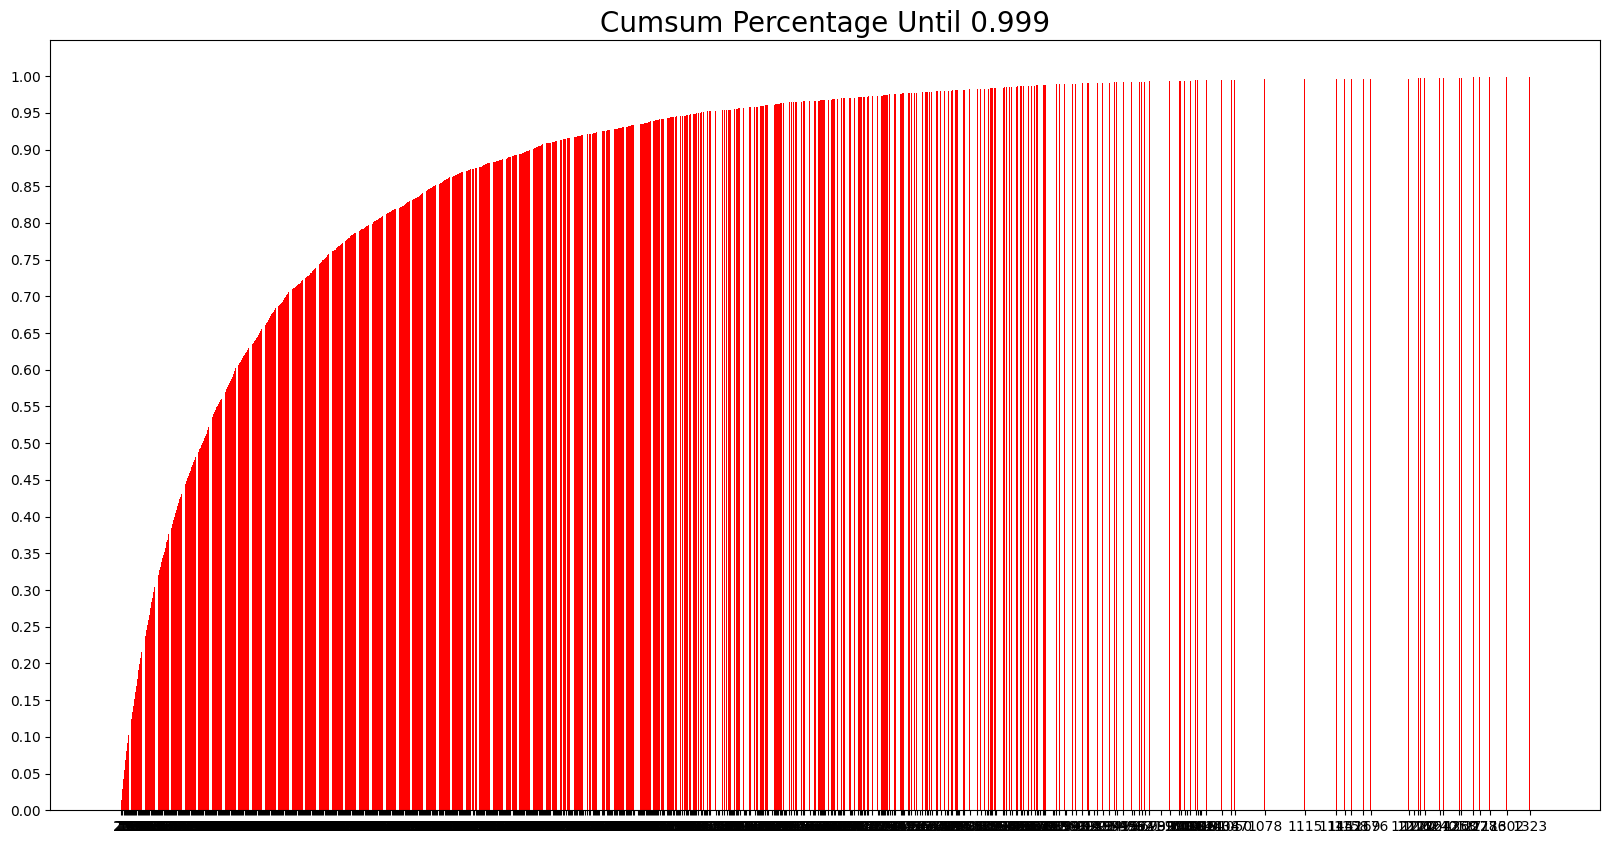

In [ ]:
# 세션 길이 시각화 (이상치 확인)
# 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [ ]:
# 시간 관련 정보 확인
oldest, latest = data['Time'].min(), data['Time'].max()
oldest, latest

(956703932, 1046454590)

In [ ]:
# timestamp를 time_struct 타입으로 변환
import time

tm_old = time.gmtime(oldest)
print(tm_old)

tm_latest = time.gmtime(latest)
print(tm_latest)

time.struct_time(tm_year=2000, tm_mon=4, tm_mday=25, tm_hour=23, tm_min=5, tm_sec=32, tm_wday=1, tm_yday=116, tm_isdst=0)
time.struct_time(tm_year=2003, tm_mon=2, tm_mday=28, tm_hour=17, tm_min=49, tm_sec=50, tm_wday=4, tm_yday=59, tm_isdst=0)


### 2000년 4월 25일부터 2003년 2월 28일까지의 데이터가 있음

**session(user_id)별로 다음에 볼 영화를 예측**

즉, 영화를 추천(예측)하는 시스템은 사용자의 평가(Rating)가 중요

평가(Rating) 분포를 확인

<Axes: xlabel='Rating', ylabel='Density'>

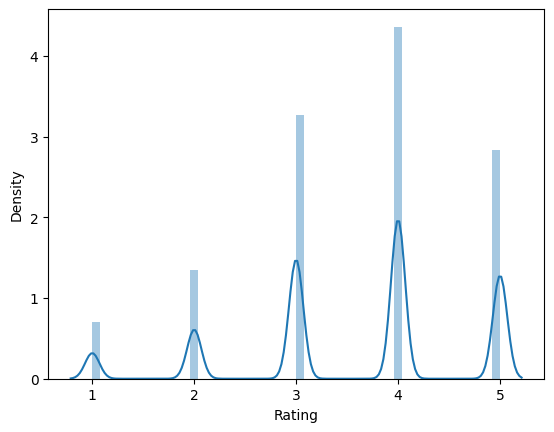

In [ ]:
import seaborn as sns
sns.distplot(data['Rating'])

**평점이 낮은 영화는 추천이 되어도 좋은 추천 시스템이 아니라고 생각하기 때문에 평점 1,2에 해당 데이터는 삭제**

In [ ]:
data = data[data['Rating']>=3]
len(data)

836478

In [ ]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [ ]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다.

Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.


단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()


    # n_days를 timedelta 객체로 변환합니다.
    n_days_timedelta = dt.timedelta(days=n_days)

    # 각 세션의 시간 간격을 계산합니다.
    time_intervals = session_last_time.apply(lambda x: final_time - x)

    # 시간 간격이 n_days보다 작은 세션을 선택합니다.
    session_in_train = time_intervals[time_intervals < n_days_timedelta].index

    # 시간 간격이 n_days 이상인 세션을 선택합니다.
    session_in_test = time_intervals[time_intervals >= n_days_timedelta].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    after_date = after_date[after_date['UserId'].isin(before_date['ItemId'])]
    return before_date, after_date


In [ ]:
# 'Time' 열을 datetime 형식으로 변환
data['Time'] = pd.to_datetime(data['Time'], unit='s')  # 예시: 초 단위로 저장된 경우

# split_by_date 함수 호출
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [ ]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [ ]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 828507
	 Sessions: 6037
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 3537
	 Sessions: 228
	 Items: 1540
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 3745
	 Sessions: 230
	 Items: 1558
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [ ]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [ ]:
save_path = Path('/processed')
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 3. 모델 구성


In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [ ]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 828112, 828231, 828507], dtype=int32)

In [ ]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6034, 6035, 6036])

In [ ]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=32):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """
        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [ ]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [ ]:
iter_ex = iter(tr_data_loader)

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=5)

In [ ]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 1, 3307)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               503850    
                              (128, 50)]                         
                                                                 
 dropout (Dropout)           (128, 50)                 0         
                                                                 
 dense (Dense)               (128, 3307)               168657    
                                                                 
Total params: 672507 (2.57 MB)
Trainable params: 672507 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Step 4. 모델 학습


In [ ]:
tr['UserId'].nunique()

6037

In [ ]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total= total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)

def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
train_model(model, args)


Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Evaluation:   8%|▊         | 2/25 [00:01<00:16,  1.36it/s]

1/1 [==============================] - 0s 36ms/step


Evaluation:  16%|█▌        | 4/25 [00:02<00:14,  1.44it/s]


	 - Recall@5 epoch 1: 0.021484
	 - MRR@5    epoch 1: 0.013639



Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Evaluation:   8%|▊         | 2/25 [00:01<00:12,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.77it/s]


	 - Recall@5 epoch 2: 0.021484
	 - MRR@5    epoch 2: 0.013151



Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Evaluation:   8%|▊         | 2/25 [00:01<00:15,  1.53it/s]

1/1 [==============================] - 0s 43ms/step


Evaluation:  16%|█▌        | 4/25 [00:02<00:14,  1.41it/s]

	 - Recall@5 epoch 3: 0.027344
	 - MRR@5    epoch 3: 0.015918



**epoch가 증가하면서 accuracy는 증가하고, loss는 줄어드는걸 확인할 수 있다.**

**또한 Recall 값과 MRR 값도 증가하는 것으로 보아 학습이 잘 이루어진는 것을 확인할 수 있다.**

## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\n - Recall@{args.k}: {test_recall:3f}")
    print(f"\n - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 0/27 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


Evaluation:   4%|▎         | 1/27 [00:02<01:07,  2.60s/it]

1/1 [==============================] - 0s 127ms/step


Evaluation:   7%|▋         | 2/27 [00:05<01:14,  2.97s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation:  11%|█         | 3/27 [00:09<01:13,  3.07s/it]

1/1 [==============================] - 0s 23ms/step


Evaluation:  15%|█▍        | 4/27 [00:10<00:59,  2.58s/it]


 - Recall@5: 0.173828

 - MRR@5: 0.053116



**Recall : 0.17**

**MRR : 0.053**

# 분석 및 문제확인
### 1 : 3년치 데이터를 이용해 'UserId'를 세션의 기준으로 설정함.
* Recall : 0.17
* MRR : 0.053

### 문제 : 유저를 기준으로 세션을 나누게 되면 '다음 클릭을 예측하는' 의미보다는 '유저별 영화 선호도'를 예측하는 의미가 더 커짐. 
### 💡 해결 전략 >> 시간을 기준으로 세션을 정의하여 모델에 적용 시도

# 세션정의 시도 2 : 접속시간을 기준으로 한 유저의 하루 동안의 접속을 하나의 세션으로 정의

In [2]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [3]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

### session(user_id)별로 다음에 볼 영화를 예측 (다음 클릭 예측)

1. 평점이 3미만인 데이터는 추천하기에 적합하지 않음 >> 제거


2. 1년치 데이터 사용 >> ❗️변경 : 데이터 수가 너무 작아 3년치 데이터 모두 사용


3. user id 별로 group 후 하루를 기준으로 세션을 나눔


## 평점(Rating) 확인

<AxesSubplot:xlabel='Rating', ylabel='Density'>

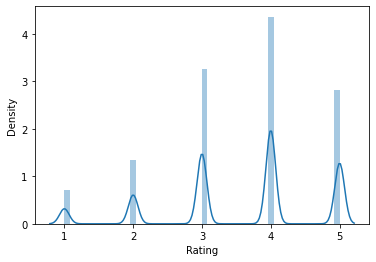

In [5]:
# 평가(Rating) 분포를 확인
import seaborn as sns
sns.distplot(data['Rating'])

### 분석 : 평점이 낮은 영화는 추천이 되어도 좋은 추천 시스템이 아니라고 생각하기 때문에 평점 1,2에 해당 데이터는 삭제

In [7]:
data = data[data['Rating']>3]
len(data)

575281

## 시간 관련 정보 확인

In [8]:
oldest, latest = data['Time'].min(), data['Time'].max()
oldest, latest

(956703932, 1046454590)

In [9]:
# timestamp를 time_struct 타입으로 변환
import time

tm_old = time.gmtime(oldest)
print(tm_old)

tm_latest = time.gmtime(latest)
print(tm_latest)

time.struct_time(tm_year=2000, tm_mon=4, tm_mday=25, tm_hour=23, tm_min=5, tm_sec=32, tm_wday=1, tm_yday=116, tm_isdst=0)
time.struct_time(tm_year=2003, tm_mon=2, tm_mday=28, tm_hour=17, tm_min=49, tm_sec=50, tm_wday=4, tm_yday=59, tm_isdst=0)


### 분석 : 2000년 4월 25일부터 2003년 2월 28일까지의 데이터가 있음

In [ ]:
# ### 1년치 데이터를 사용

# import datetime as dt
# import numpy as np

# # Unix 타임스탬프를 datetime 객체로 변환
# latest_datetime = dt.datetime.utcfromtimestamp(latest)

# # 최종 날짜로부터 1년(365일) 이전 날짜 계산
# month_ago = latest_datetime - dt.timedelta(days=365)

# # 1년 이후의 데이터만 선택
# data = data[data['Time'] > month_ago]

# # 결과 확인
# data

## 세션 정의 후 나눠주기

In [10]:
# Time 열을 datetime 형식으로 변환
data['Time'] = pd.to_datetime(data['Time'], unit='s')

# UserId로 그룹화하고 같은 날짜에 발생한 데이터끼리 1개의 세션으로 묶기
data['SessionId'] = data.groupby(['UserId', data['Time'].dt.date]).ngroup()

data[['UserId', 'Time', 'SessionId']]

,UserId,Time,SessionId
31,1,2000-12-31 22:00:19,0
22,1,2000-12-31 22:00:55,0
27,1,2000-12-31 22:00:55,0
37,1,2000-12-31 22:00:55,0
36,1,2000-12-31 22:02:52,0
...,...,...,...
1000119,6040,2001-08-10 14:39:27,19617
999923,6040,2001-08-10 14:39:58,19617
1000019,6040,2001-08-10 14:40:29,19617
999988,6040,2001-08-10 14:41:04,19617


In [11]:
# 두 개 이상의 SessionId를 가지고 있는 UserId 확인

# UserId로 그룹화하고 SessionId의 고유한 값의 개수
session_counts = data.groupby('UserId')['SessionId'].nunique()

multiple_sessions = session_counts[session_counts >= 2]
print("두 개 이상의 SessionId를 가지고 있는 UserId:\n", multiple_sessions)

두 개 이상의 SessionId를 가지고 있는 UserId:
 UserId
1        2
10       5
11       3
15       2
19      13
        ..
6028     2
6037     2
6038     2
6039     2
6040    10
Name: SessionId, Length: 2445, dtype: int64


In [12]:
# 확인용 예시 출력
data[data['UserId'] == 1]

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,0
27,1,1721,4,2000-12-31 22:00:55,0
37,1,1022,5,2000-12-31 22:00:55,0
36,1,1836,5,2000-12-31 22:02:52,0
3,1,3408,4,2000-12-31 22:04:35,0
7,1,2804,5,2000-12-31 22:11:59,0
47,1,1207,4,2000-12-31 22:11:59,0
0,1,1193,5,2000-12-31 22:12:40,0
44,1,260,4,2000-12-31 22:12:40,0


## 세션 길이 확인

In [16]:
# 세션당 몇개의 클릭(영화)를 가지고 있는지 확인
session_length = data.groupby('SessionId').size()

session_length.min(), session_length.max(), session_length.mean(), session_length.median()

(1, 741, 29.322646414190327, 7.0)

In [17]:
session_length.quantile(0.999)

470.43800000001283

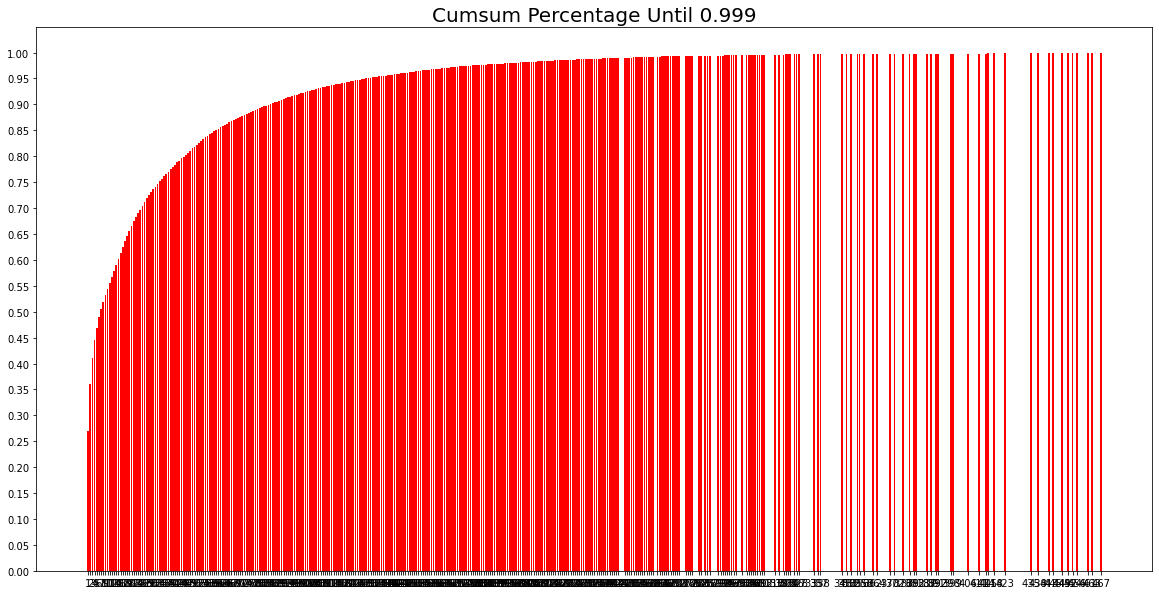

In [18]:
# 세션 길이 시각화 (이상치 확인)
# 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 분석 : 세션길이가 470 이하의 데이터만으로도 충분히 99%의 데이터를 설명할 수 있으므로 outlier가 될 수 있는 session 길이가 470 데이터는 제거

In [19]:
# 세션 길이 확인
# 세션 길이가 470 이하인 UserId 선택
valid_session_ids = session_length[session_length <= 470].index

# 유효한 UserId를 가진 데이터만 선택
data = data[data['SessionId'].isin(valid_session_ids)]
data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,0
27,1,1721,4,2000-12-31 22:00:55,0
37,1,1022,5,2000-12-31 22:00:55,0
36,1,1836,5,2000-12-31 22:02:52,0
...,...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27,19617
999923,6040,232,5,2001-08-10 14:39:58,19617
1000019,6040,2917,4,2001-08-10 14:40:29,19617
999988,6040,1921,4,2001-08-10 14:41:04,19617


## Data Cleansing
길이가 1인 세션도 있음 >> 우리의 목적은 유저가 최소 2개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거

**노드에서는 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있어 제거해줬지만, 이미 평점이 낮은 데이터를 제거했기때문에 이 과정은 생략**

In [34]:
# 길이가 1인 세션이 존재하는지 확인
shortest = 2
session_len = data.groupby('SessionId').size()
session_use = session_len[session_len < shortest].index
session_use

Int64Index([   22,    29,    31,    33,    34,    36,    54,    79,    90,
              121,
            ...
            19539, 19542, 19543, 19563, 19567, 19568, 19594, 19615, 19616,
            19618],
           dtype='int64', name='SessionId', length=5288)

In [38]:
# 하나의 예시(index = 22) 확인
print(data[data['SessionId'] == 22])
data[data['UserId'] == 15][90:]

      UserId  ItemId  Rating                Time  SessionId
1520      15    3510       5 2001-01-01 15:03:13         22


,UserId,ItemId,Rating,Time,SessionId
1545,15,1422,4,2000-12-30 21:41:03,21
1685,15,1597,4,2000-12-30 21:41:03,21
1569,15,3489,4,2000-12-30 21:43:11,21
1521,15,1196,4,2000-12-30 21:43:48,21
1560,15,260,4,2000-12-30 21:44:05,21
1656,15,1210,4,2000-12-30 21:44:23,21
1547,15,3461,4,2000-12-30 21:44:58,21
1693,15,2115,4,2000-12-30 21:45:20,21
1520,15,3510,5,2001-01-01 15:03:13,22


In [39]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        #data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


# def cleanse_unpopular_item(data: pd.DataFrame, least_click):
#     item_popular = data.groupby('ItemId').size()
#     item_use = item_popular[item_popular >= least_click].index
#     data = data[data['ItemId'].isin(item_use)]
#     return data

In [40]:
data = cleanse_recursive(data, shortest=2)
len(data)

564109

## step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다.

Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.


단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [41]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [42]:
# 'Time' 열을 datetime 형식으로 변환
data['Time'] = pd.to_datetime(data['Time'], unit='s')  # 예시: 초 단위로 저장된 경우

# split_by_date 함수 호출
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [43]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [44]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 559309
	 Sessions: 6029
	 Items: 3514
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 2265
	 Sessions: 207
	 Items: 1106
	 First Time : 2002-09-01 04:16:16
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 2533
	 Sessions: 207
	 Items: 1198
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [45]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [46]:
save_path = Path('/processed')
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 3. 모델 구성


In [65]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [66]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,0,0
22,1,1270,5,2000-12-31 22:00:55,0,1
27,1,1721,4,2000-12-31 22:00:55,0,2
37,1,1022,5,2000-12-31 22:00:55,0,3
36,1,1836,5,2000-12-31 22:02:52,0,4
3,1,3408,4,2000-12-31 22:04:35,0,5
7,1,2804,5,2000-12-31 22:11:59,0,6
47,1,1207,4,2000-12-31 22:11:59,0,7
0,1,1193,5,2000-12-31 22:12:40,0,8
44,1,260,4,2000-12-31 22:12:40,0,9


In [68]:
tr_dataset.click_offsets

array([     0,     34,     45, ..., 559291, 559308, 559309], dtype=int32)

In [69]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 18657, 18658, 18659])

In [70]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=32):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """
        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [71]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,0,0
22,1,1270,5,2000-12-31 22:00:55,0,1
27,1,1721,4,2000-12-31 22:00:55,0,2
37,1,1022,5,2000-12-31 22:00:55,0,3
36,1,1836,5,2000-12-31 22:02:52,0,4
3,1,3408,4,2000-12-31 22:04:35,0,5
7,1,2804,5,2000-12-31 22:11:59,0,6
47,1,1207,4,2000-12-31 22:11:59,0,7
0,1,1193,5,2000-12-31 22:12:40,0,8
44,1,260,4,2000-12-31 22:12:40,0,9


In [72]:
iter_ex = iter(tr_data_loader)

In [73]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 34 45 52]
Label Item Idx are :       [  1  35  46 112]
Previous Masked Input Idx are []


In [74]:
# 평가 지표 함수 만들기
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [76]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [77]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=5)

In [78]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3514)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    534900    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3514)               179214    
Total params: 714,114
Trainable params: 714,114
Non-trainable params: 0
_________________________________________________________________


In [79]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [80]:
train_model(model, args)

Evaluation:  14%|█▍        | 2/14 [00:03<00:18,  1.53s/it]


	 - Recall@5 epoch 1: 0.019531
	 - MRR@5    epoch 1: 0.014323



Evaluation:  14%|█▍        | 2/14 [00:00<00:03,  3.99it/s]


	 - Recall@5 epoch 2: 0.023438
	 - MRR@5    epoch 2: 0.011849



Evaluation:  14%|█▍        | 2/14 [00:00<00:02,  4.03it/s]

	 - Recall@5 epoch 3: 0.027344
	 - MRR@5    epoch 3: 0.017383



**epoch가 증가하면서 accuracy는 증가하고, loss는 줄어드는걸 확인할 수 있다.**

**또한 Recall 값과 MRR 값도 증가하는 것으로 보아 학습이 잘 이루어진는 것을 확인할 수 있다.**

## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [82]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\n - Recall@{args.k}: {test_recall:3f}")
    print(f"\n - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 3/16 [00:01<00:07,  1.64it/s]


 - Recall@5: 0.109375

 - MRR@5: 0.038323



**Recall : 0.10**

**MRR : 0.038**

## 1. 세션정의를 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰

### 1 : 3년치 데이터를 이용해 'UserId'를 세션의 기준으로 설정함.
* Recall : 0.17
* MRR : 0.053

### 2 : 3년치 데이터를 이용해 '접속시간 : 1일'을 세션의 기준으로 설정함.
* Recall : 0.10
* MRR : 0.038

### 분석 : 비록 recall 값과 mrr 값은 감소했지만, session-based recommendation의 원리와 의미를 고려할 때, 접속시간을 기준으로 세션을 나눠 추천시스템을 구축한 것이 더 유의미해 보인다.


## 2. 하이퍼파라미터를 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰

In [95]:
del model

In [98]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.00001, epochs=10, k=20)

In [99]:
model = create_model(args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(128, 1, 3514)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    534900    
_________________________________________________________________
dropout_7 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_7 (Dense)              (128, 3514)               179214    
Total params: 714,114
Trainable params: 714,114
Non-trainable params: 0
_________________________________________________________________


In [100]:
train_model(model, args)

Evaluation:  14%|█▍        | 2/14 [00:01<00:08,  1.39it/s]


	 - Recall@20 epoch 1: 0.058594
	 - MRR@20    epoch 1: 0.015105



Evaluation:  14%|█▍        | 2/14 [00:01<00:07,  1.62it/s]


	 - Recall@20 epoch 2: 0.050781
	 - MRR@20    epoch 2: 0.013013



Evaluation:  14%|█▍        | 2/14 [00:01<00:07,  1.53it/s]


	 - Recall@20 epoch 3: 0.054688
	 - MRR@20    epoch 3: 0.008981



Evaluation:  14%|█▍        | 2/14 [00:01<00:08,  1.48it/s]


	 - Recall@20 epoch 4: 0.058594
	 - MRR@20    epoch 4: 0.008706



Evaluation:  14%|█▍        | 2/14 [00:01<00:07,  1.61it/s]


	 - Recall@20 epoch 5: 0.058594
	 - MRR@20    epoch 5: 0.008788



Evaluation:  14%|█▍        | 2/14 [00:01<00:07,  1.58it/s]


	 - Recall@20 epoch 6: 0.058594
	 - MRR@20    epoch 6: 0.007486



Evaluation:  14%|█▍        | 2/14 [00:01<00:07,  1.61it/s]


	 - Recall@20 epoch 7: 0.058594
	 - MRR@20    epoch 7: 0.007640



Evaluation:  14%|█▍        | 2/14 [00:01<00:07,  1.57it/s]


	 - Recall@20 epoch 8: 0.058594
	 - MRR@20    epoch 8: 0.007640



Evaluation:  14%|█▍        | 2/14 [00:01<00:07,  1.59it/s]


	 - Recall@20 epoch 9: 0.058594
	 - MRR@20    epoch 9: 0.007640



Evaluation:  14%|█▍        | 2/14 [00:01<00:08,  1.49it/s]

	 - Recall@20 epoch 10: 0.058594
	 - MRR@20    epoch 10: 0.007670



In [101]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\n - Recall@{args.k}: {test_recall:3f}")
    print(f"\n - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 3/16 [00:01<00:08,  1.58it/s]


 - Recall@20: 0.057292

 - MRR@20: 0.013816



## 분석 
### arg 변경 전
* train final accuracy : 0.0156
* train final loss : 5.63
* test Recall : 0.17
* test MRR : 0.053

### arg 변경 후
* train final accuracy : 0.00781
* train final loss : 7.16
* test Recall : 0.057292
* test MRR : 0.013816

### 분석 : Train 과정에서 accuracy가 감소하여 0에 가깝게 수렴하였지만, train loss는 10번째 epoch까지 꾸준히 감소하였다. arg변경 전과 비교하였을때, accuracy는 감소하였고 loss값은 증가하였기에 arg변경 전의 모델이 더 적절하다는 것을 알 수 있다. 또한 test 결과는 recall값이  0.17에서 0.057로 약 66.47% 감소하였다. mrr 값은 0.053에서 0.013으로 약 75.47% 감소하였다. arg를 변경한 후에 recall값도 감소하였고, 순서에 민감한 지표인 mrr이 감소한 것을 고려하면 현재 추천시스템의 목표와는 멀어진 것으로 보인다.

## 3. 모델구조를 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰
: 논문에서는 Embedding Layer를 추가하는 것이 오히려 성능을 떨어뜨린다고 하였다. 확인을 위해서 embedding layer를 추가하여 비교해보고자 한다.

In [122]:
del model

In [123]:
from keras.layers import Embedding, Input, GRU, Dropout, Dense
from keras.models import Model
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k, embedding_dim):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
        self.embedding_dim = embedding_dim

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, args.num_items,))
    embedding = Embedding(input_dim=args.num_items, output_dim=args.embedding_dim)(inputs)
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(embedding)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    return model

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            input_ohe = input_ohe.reshape(-1, input_ohe.shape[-1])  

            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  
    hidden_states = gru_layer.states[0].numpy()  
    for elt in mask:  
        hidden_states[elt, :] = 0  
    gru_layer.reset_states(states=hidden_states)

def get_metrics(data, model, args, k: int):  
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        input_ohe = input_ohe.reshape(-1, input_ohe.shape[-1])  

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

# 모델 생성과 컴파일 분리
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=5, embedding_dim=32)
model = create_model(args)
model.summary()
train_model(model, args)


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(128, 3514)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (128, 3514, 32)           112448    
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    12600     
_________________________________________________________________
dropout_11 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_11 (Dense)             (128, 3514)               179214    
Total params: 304,262
Trainable params: 304,262
Non-trainable params: 0
_________________________________________________________________


Evaluation:  14%|█▍        | 2/14 [00:00<00:04,  2.48it/s]


	 - Recall@5 epoch 1: 0.011719
	 - MRR@5    epoch 1: 0.003385



Evaluation:  14%|█▍        | 2/14 [00:00<00:03,  3.53it/s]


	 - Recall@5 epoch 2: 0.011719
	 - MRR@5    epoch 2: 0.003385



Evaluation:  14%|█▍        | 2/14 [00:00<00:03,  3.32it/s]

	 - Recall@5 epoch 3: 0.011719
	 - MRR@5    epoch 3: 0.003385



In [124]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\n - Recall@{args.k}: {test_recall:3f}")
    print(f"\n - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 3/16 [00:02<00:09,  1.42it/s]


 - Recall@5: 0.049479

 - MRR@5: 0.015503



## 분석 
### 기존 모델
* train final accuracy : 0.0156
* train final loss : 5.63
* test Recall : 0.17
* test MRR : 0.053

### embedding layer 추가 후
* train final accuracy : 0.00781
* train final loss : 7.12
* test Recall : 0.049479
* test MRR : 0.015503

### 분석 : Recall 값은 0.17에서 0.049479로 감소하였고, MRR 값은 0.053에서 0.015503로 감소하였다. 이를 고려하였을때, 논문에서 언급된 바와 같이 embedding layer를 추가하는 것이 더 낮은 효율을 내는것으로 보인다.